In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
import random
from utilities import *
from datasetVariables import *

In [2]:
def normalizeDataSet(dataArray):    
    normalizationParameters = loadData("normalization_parameters")    
    divI = normalizationParameters["divI"]
    divPhase = normalizationParameters["divPhase"]
    dataArray[:,:,0:6,0] = dataArray[:,:,0:6,0]/divI
    dataArray[:,:,6:9,0] = dataArray[:,:,6:9,0]/divPhase    
    return dataArray

In [3]:
def getBenignData(featureTitleList):
    dataList = []
    for faultType in os.listdir(rawDataDir):
        faultTypeDir = '/'.join([rawDataDir,faultType])
        if(os.path.isdir(faultTypeDir)):
            for generationLevel in os.listdir(faultTypeDir):
                generationLevelDir = '/'.join([faultTypeDir,generationLevel]) 
                if(os.path.isdir(generationLevelDir)):
                    ttl = len(os.listdir(generationLevelDir))
                    with tqdm.tqdm(total=ttl) as p_bar:                             
                        processed = 0;
                        for dirName in os.listdir(generationLevelDir):
                            dataDir = '/'.join([generationLevelDir,dirName])                                                    
                            for fileName in os.listdir(dataDir):
                                filePath = '/'.join([dataDir,fileName]) 
                                mat = scipy.io.loadmat(filePath)                               
                                toAddSubSequence = []                                
                                faultIndex = mat["Fault_Index"][0][0]                                                                  
                                randInt = random.randint(1,101)
                                startIndex = 500 + randInt
                                endIndex = 700 + randInt                                    
                                for feature in featureTitleList:  
                                    toAppendArr = mat[feature][startIndex:endIndex]                                                                        
                                    toAddSubSequence.append(toAppendArr) 
                                dataList.append(toAddSubSequence)                            
                            p_bar.update(1)    
    return np.swapaxes(np.array(dataList), 1, 2)

In [4]:
def getShiftedAngleData(featureTitleList, featuresToShift, count, shiftRange = 20):
    dataList = []
    for faultType in os.listdir(rawDataDir):
        faultTypeDir = '/'.join([rawDataDir,faultType])
        if(os.path.isdir(faultTypeDir)):
            for generationLevel in os.listdir(faultTypeDir):
                generationLevelDir = '/'.join([faultTypeDir,generationLevel]) 
                if(os.path.isdir(generationLevelDir)):      
                    ttl = len(os.listdir(generationLevelDir)) 
                    with tqdm.tqdm(total=ttl) as p_bar:                             
                        processed = 0;
                        for dirName in os.listdir(generationLevelDir):
                            dataDir = '/'.join([generationLevelDir,dirName])                                                    
                            for fileName in os.listdir(dataDir):
                                filePath = '/'.join([dataDir,fileName]) 
                                mat = scipy.io.loadmat(filePath)                               
                                toAddSubSequence = []                                                                                                                                  
                                randInt = random.randint(1,101)
                                startIndex = 500 + randInt
                                endIndex = 700 + randInt    
                                shiftBy = random.randint(5,shiftRange)
                                for feature in featureTitleList:  
                                    toAppendArr = mat[feature][startIndex:endIndex]                                    
                                    if(feature in featuresToShift):
                                        shiftedHalfStartIndex = int(startIndex+sequenceLen/2-shiftBy)
                                        shiftedHalfEndIndex = int(endIndex-shiftBy)
                                        attackStartIndex = int(sequenceLen/2)
                                        toAppendArr[attackStartIndex:] = mat[feature][shiftedHalfStartIndex:shiftedHalfEndIndex]
                                    toAddSubSequence.append(toAppendArr) 
                                dataList.append(toAddSubSequence)                                                        
                            p_bar.update(1) 
    smapledList = random.sample(dataList, count)
    return np.swapaxes(np.array(smapledList), 1, 2)

In [5]:
def getRandomFDIAttackData(featuresIndexesToAttack, count):
    benignData = loadData("benign_data_set")
    sampledBenignDataList = random.sample(list(benignData), count)
    sampledBenignDataArr = np.array(sampledBenignDataList)
    ttl = len(sampledBenignDataArr)
    with tqdm.tqdm(total=ttl) as p_bar:              
        processed = 0;  
        for dataSeq in sampledBenignDataArr:                                                                                                        
            for featureIndex in featuresIndexesToAttack:  
                randArr = np.random.rand(count,sequenceLen)                
                sampledBenignDataArr[:,:,featureIndex,0] = randArr                                                                 
            p_bar.update(1) # One is processed
            
    return sampledBenignDataArr

In [6]:
# get benign data and save 
benignData = getBenignData(["Iprobe1_a","Iprobe1_b","Iprobe1_c","Iprobe2_a","Iprobe2_b","Iprobe2_c","PhaseAngle_a","PhaseAngle_b","PhaseAngle_c"])
normalizedBenignData = normalizeDataSet(benignData.copy())
saveData(normalizedBenignData, "benign_data_set")

100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [02:18<00:00,  1.56it/s]


In [8]:
# generate FDI attack data and save
# generate angle shift attack data and save
FDIAttackData = getRandomFDIAttackData([0,1,2],1000)
normalizedFDIAttackData = normalizeDataSet(FDIAttackData.copy())
saveData(normalizedFDIAttackData, "normalized_fdi_attack_data_set")

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 155.86it/s]


In [7]:
# generate angle shift attack data and save
angleShiftAttackData = getShiftedAngleData(["Iprobe1_a","Iprobe1_b","Iprobe1_c","Iprobe2_a","Iprobe2_b","Iprobe2_c","PhaseAngle_a","PhaseAngle_b","PhaseAngle_c"]
                                  ,["PhaseAngle_a","PhaseAngle_b","PhaseAngle_c"]
                                  ,1000)
normalizedAngleShiftAttackData = normalizeDataSet(angleShiftAttackData.copy())
saveData(normalizedAngleShiftAttackData, "normalized_angle_shift_attack_data_set")

100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [02:11<00:00,  1.65it/s]


In [10]:
# Time sync attack
timeSyncAttackData = getShiftedAngleData(["Iprobe1_a","Iprobe1_b","Iprobe1_c","Iprobe2_a","Iprobe2_b","Iprobe2_c","PhaseAngle_a","PhaseAngle_b","PhaseAngle_c"]
                                  ,["Iprobe1_a","Iprobe1_b","Iprobe1_c","PhaseAngle_a","PhaseAngle_b","PhaseAngle_c"]
                                  ,1000)
normalizedTimeSyncAttackData = normalizeDataSet(timeSyncAttackData.copy())
saveData(normalizedTimeSyncAttackData, "normalized_time_sync_attack_data_set")

100%|████████████████████████████████████████████████████████████████████████████████| 216/216 [02:32<00:00,  1.41it/s]


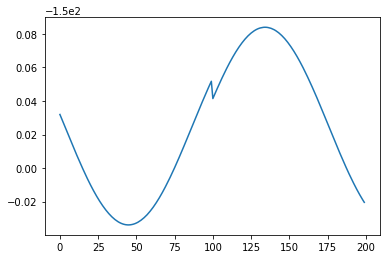

In [34]:
plt.plot(angleShiftAttackData[1,:,7])

In [13]:
FDIAttackData(1,:,0).shape

SyntaxError: invalid syntax (<ipython-input-13-ff2acae9a541>, line 1)